# 07-3 신경망 모델 훈련
인공 신경망 모델을 훈련하는 모범 사례와 필요한 도구들을 살펴본다. 이런 도구들을 다뤄 보면서 텐서플로와 케라스 API에 더 익숙해 질 수 있을 것이다.

## 손실 곡선

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

  # if 구문의 역할? model_fn() 함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것

In [5]:
model = model_fn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
# fit() 메서드의 결과를 history 변수에 담음
# 케라스의 fit() 메서드는 History 클래스 객체를 반환하는데, History 객체에는 훈련 과정에서 계산한 지표인 손실과 정확도 값이 저장되어 있다.
# verbose 매개변수는 훈련 과정 출력을 조절. 기본값은 1이고, 2로 바꾸면 진행 막대 x, 0은 훈련 과정 표시 x

print(history.history.keys())

dict_keys(['loss', 'accuracy'])


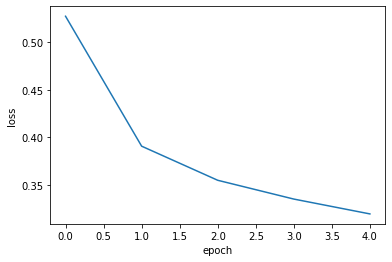

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

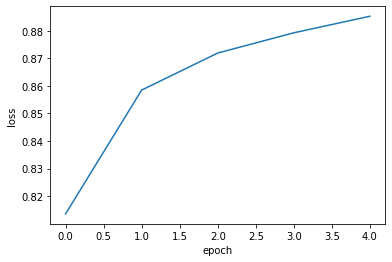

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

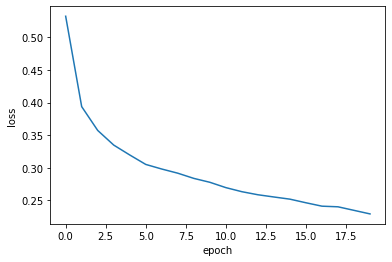

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
# 인공 신경망 모델이 최적화하는 대상은 정확도가 아닌 손실 함수이다.
# 따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 좋다.

## 검증 손실
인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 여기에도 적용된다.

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다. 따라서 앞에서처럼 훈련 세트의 손실만 그려서는 안된다.

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
# 에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


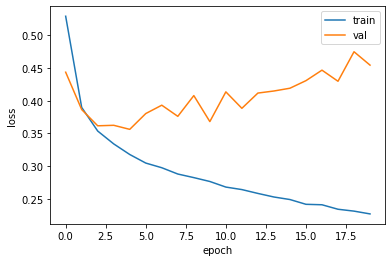

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

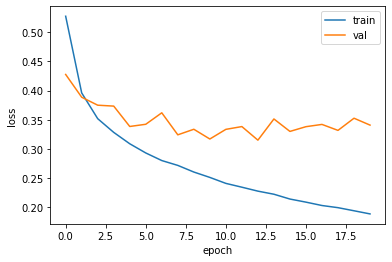

In [12]:
# 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완하시킬 수 있는지 확인해보자
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 과대적합이 훨씬 줄었당! ><

## 드롭아웃
은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법이다. 드롭아웃은 훈련 중에 적용되며 평가나 예측에서는 적용하지 않는다. 테서플로는 이를 자동으로 처리한다.

In [13]:
# 앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가한다. 30% 정도를 드롭아웃한다.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


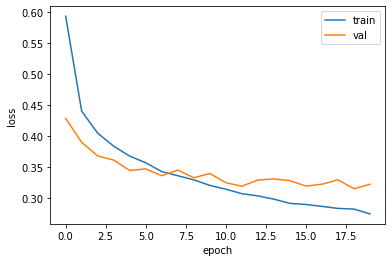

In [14]:
# 평가와 예측에 모델을 사용할 때는 드롭아웃이 적용되지 않는다.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

In [16]:
# 케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드를 제공한다
# 기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.
model.save_weights('model-weights.h5')

In [17]:
# 모델 구조와 모델 파라미터를 저장하는 save() 메서드를 제공한다
# 기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.
model.save('model-whole.h5')

In [18]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Oct 13 07:07 model-weights.h5
-rw-r--r-- 1 root root 982664 Oct 13 07:07 model-whole.h5


In [19]:
# 1. 훈련을 하지 않은 새로운 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))
# 모델의 검증 정확도

375/375 [==============================] - 1s 1ms/step
0.87625


In [20]:
# 2. model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용한다.
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)
# 같은 모델을 저장하고 다시 불러들였기 때문에 위와 동일한 정확도 얻음

375/375 [==============================] - 1s 4ms/step - loss: 0.3434 - accuracy: 0.8763


[0.34341761469841003, 0.8762500286102295]

## 콜백
케라스 모델을 훈련하는 도중에 어떤 작업을 수행할 수 있도록 도와주는 도구이다. 대표적으로 최상의 모델을 자동으로 저장해 주거나 검증 점수가 더 이상 향상되지 않으면 일찍 종료할 수 있다.

In [21]:
# ModelCheckpoint 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 저장한다.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [22]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3256 - accuracy: 0.8869


[0.3256276249885559, 0.8869166374206543]

In [23]:
# 케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 조기종료란 과대적합이 커지기 전에 훈련을 미리 중지하는 걸 뜻한다.
# 예를 들어 patience=2 로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다.
# 또한 restore_best_weights=True 로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

In [24]:
print(early_stopping_cb.stopped_epoch)
# 에포크 횟수가 0부터 시작했기 때문에 epochs = n은 n+1번째 에포크에서 훈련이 중지되었다는 것을 의미한다.
# patience = 2로 지정했으므로 최상의 모델은 n-1번째 에포크일 것이다.

12


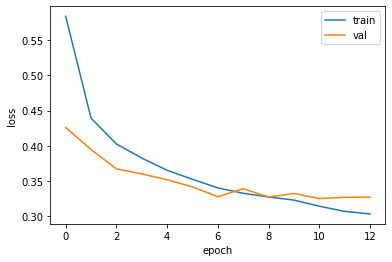

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [26]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3250 - accuracy: 0.8832


[0.32501325011253357, 0.8831666707992554]